In [63]:
#!/usr/bin/python
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from pprint import pprint
#from tools.feature_format import feature_format, targetFeatureSplit
#from final_project.tester import dump_classifier_and_data

%matplotlib inline


## Data Exploration

First we'll load the the data into a pandas Dataframe

In [2]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient='index')


In [66]:
[print(x) for x in df.columns.to_list()]

salary
to_messages
deferral_payments
total_payments
loan_advances
bonus
email_address
restricted_stock_deferred
deferred_income
total_stock_value
expenses
from_poi_to_this_person
exercised_stock_options
from_messages
other
from_this_person_to_poi
poi
long_term_incentive
shared_receipt_with_poi
restricted_stock
director_fees


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [67]:
df.salary.describe()

count    9.400000e+01
mean     2.840875e+05
std      1.771311e+05
min      4.770000e+02
25%      2.118020e+05
50%      2.587410e+05
75%      3.086065e+05
max      1.111258e+06
Name: salary, dtype: float64

Total number of data points

In [14]:
# Total number of data points

print("Observations: {0}\nFeatures: {1}".format(*df.shape))

Observations:146
Features:21


Allocation across classes(POI/non-POI)

In [20]:
# Allocation across classes(POI/non-POI)
# df.poi.value_counts()
df['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

Number of features used

In [ ]:
# TODO: add number of features to be used

## Are there features with many missing values?

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
loan_advances                146 non-null object
bonus                        146 non-null object
email_address                146 non-null object
restricted_stock_deferred    146 non-null object
deferred_income              146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
from_poi_to_this_person      146 non-null object
exercised_stock_options      146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
long_term_incentive          146 non-null object


In [42]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))


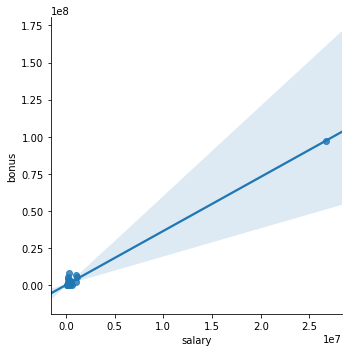

In [47]:
sns.lmplot(x='salary', y='bonus', data=df)

In [46]:
# Finance features in dataset, should be type Int
financial_features = ['salary', 'deferral_payments',
                      'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred',
                      'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                      'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

# email_address itself ommitted here for cleaning
email_features = ['to_messages', 'from_poi_to_this_person',
                  'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
# Columns that should be integer data type
int_cols = email_features + financial_features
# binary value to denote whether person is known person of interest

poi_label = ['poi']

# fix 'Nan' String
# df = df.replace('NaN', np.nan)
# fix columns from float to int64
for c in int_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')


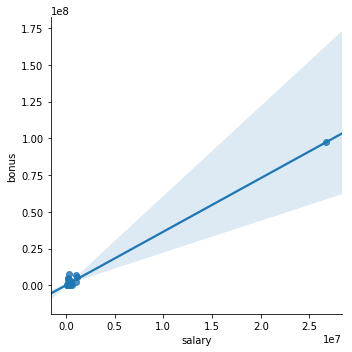

In [48]:
# salary by bonus plot before 'TOTAL' removal
sns.lmplot(x='salary', y='bonus', data=df)
# the 'TOTAL' record
TOTAL = df.sort_values(by=['salary'], ascending=False, na_position='last').head(1)


## Data Exploration


### Issues

* NaN strings affecting column datatype in pandas
* Aggregate Features: Total Payments, Total Stock Value
* Aggregate Record: TOTAL
* Non-person entity record: 'THE TRAVEL AGENCY IN THE PARK'

## Features

### Payment Features

* Salary: int
    > Reflects items such as base salary, executive cash allowances, and benefits payments.
* Bonus
    > Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.
* Long Term Incentive: int
    > Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured
against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.
* Deferred Income: int
    > Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors
under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.
* Deferral Payments: int
    > Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.
* Loan Advances: int
    > Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the
promissory notes allow for the option to repay with stock of the company.
* Other
    > Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e.
housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to
employment agreements, as well as imputed income amounts for such things as use of corporate aircraft.
* Expenses
    > Reflects reimbursements of business expenses. May include fees paid for consulting services.
* Director Fees
    >  Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.

### Stock Value Features
> In 1998, 1999 and 2000, Debtor and non-debtor affiliates were charged for options granted. The Black-Scholes method was used to determine the amount to be
charged. Any amounts charged to Debtor and non-debtor affiliates associated with the options exercised related to these three years have not been subtracted
from the share value amounts shown.

* Exercised Stock Options
    > Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through
cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and
the timing of any subsequent sale of the securities.
* Restricted Stock Options
    > Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting
periods, regardless of whether deferred.
* Restricted Stock Deferred
    > Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.


 
* loan_advances
* bonus
* email_address
* restricted_stock_deferred
* deferred_income
* total_stock_value
* expenses
* from_poi_to_this_person
* exercised_stock_options
* from_messages
* other
* from_this_person_to_poi
* poi
* long_term_incentive
* shared_receipt_with_poi
* restricted_stock
* director_fees

* want to find outliers in the form of POI but not other outliers
* we know from the mini-projects that the index entry name 'TOTAL' is the wrong kind of outlier that we want
* Manual inspection of index names also revealed the existence of 'THE TRAVEL AGENCY IN THE PARK"
    * Seems to be the travel agency of choice for Enron employees.  Essentially mandatory to use for Enron employees.
    * Not a 'person' and not an Enron employee.  Also many NaN fields including Email Address.  Dropping this col.


In [52]:
# dropping computed 'TOTAL' observation
df.drop(index='TOTAL', inplace=True)

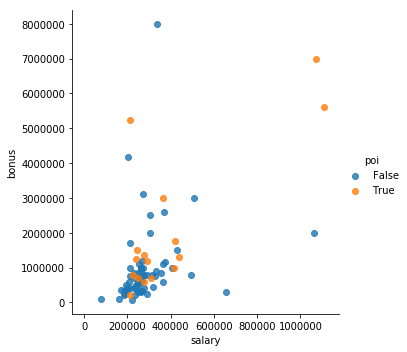

In [55]:
# salary by bonus plot after 'TOTAL' removal
sns.lmplot(x='salary', y='bonus', data=df,
           fit_reg=False, # No regression line
           hue='poi')

In [69]:
[print(x)for x in df.columns.to_list() if 'total' in x]






total_payments
total_stock_value


[None, None]

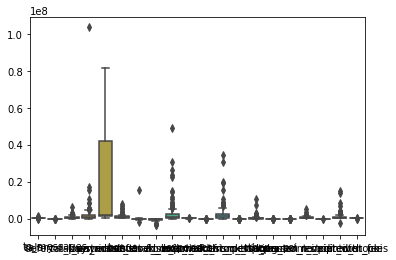

In [56]:
sns.boxplot(data=df)


C:\Users\Riley\Anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Riley\Anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\Riley\Anaconda3\envs\py37\lib\site-packages\matplotlib\axes\_axes.py:6575: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\Riley\Anaconda3\envs\py37\lib\site-packages\matplotlib\axes\_axes.py:6576: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: max must be larger than min in range parameter.

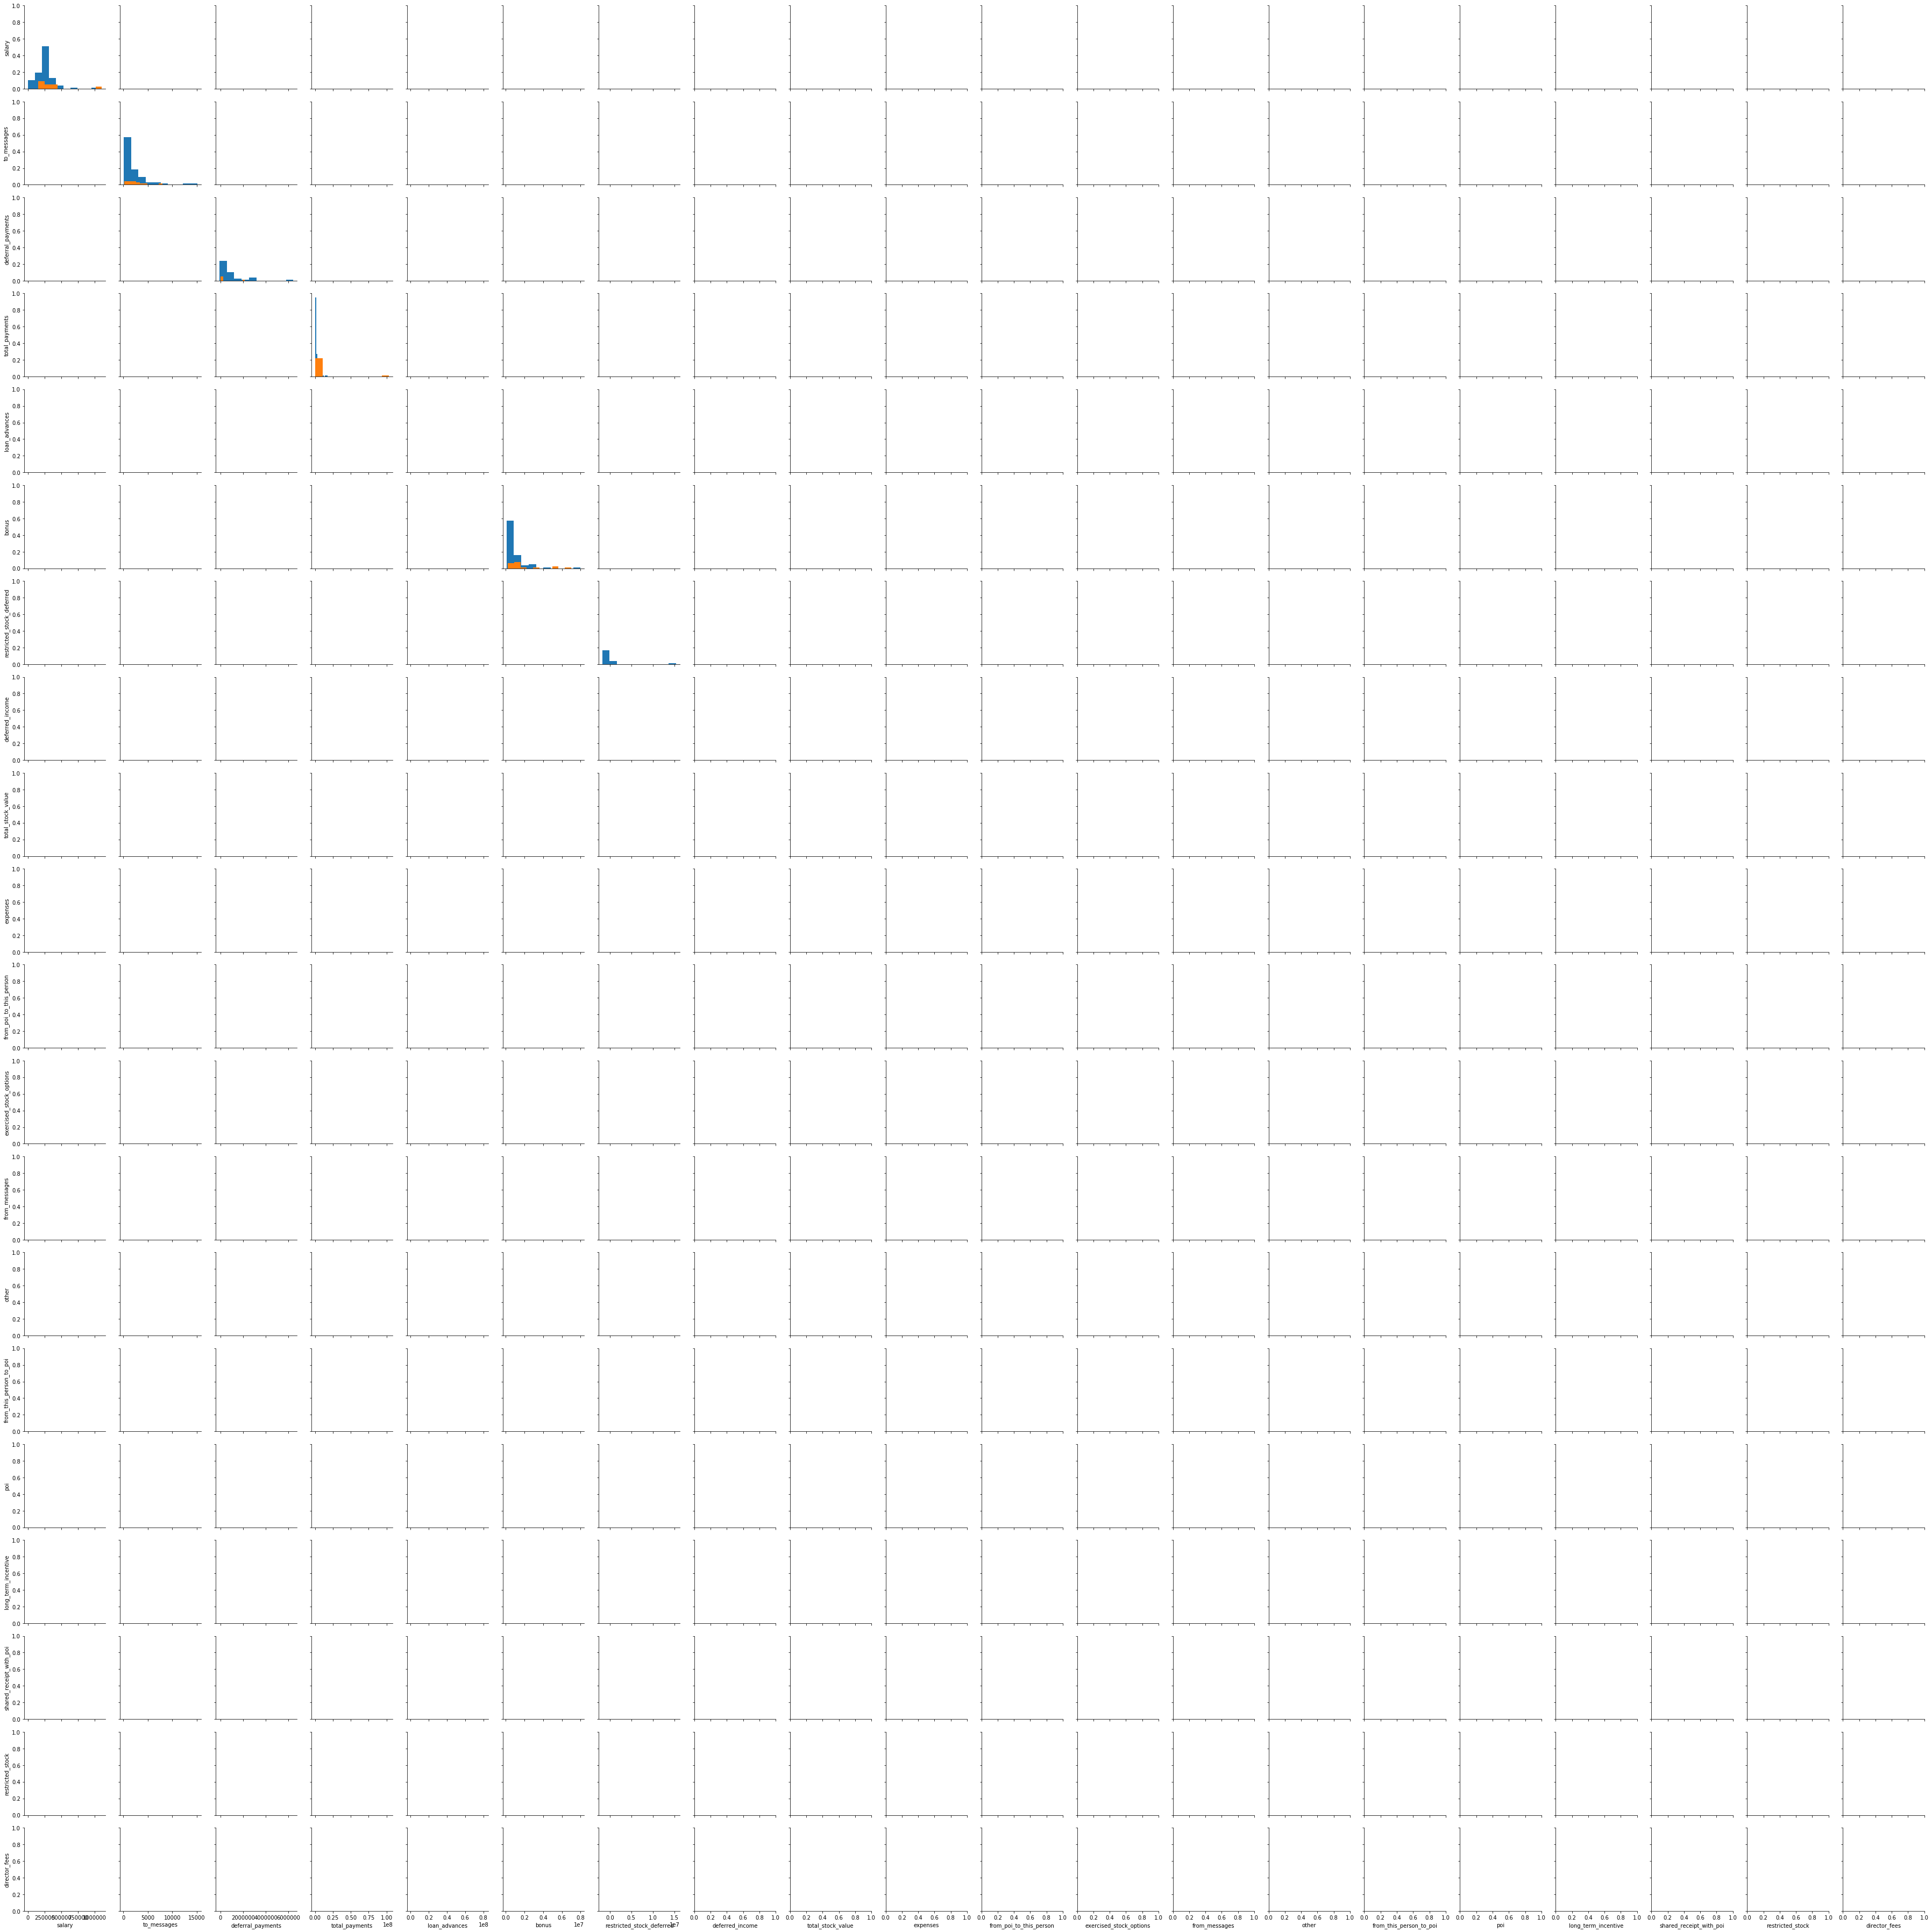

In [68]:
%%time
g = sns.PairGrid(df, hue="poi")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend(); # semi-colon to hide unsiqhtly __repl__ call
